In [263]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt 
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from pathlib import Path
from imutils.paths import list_images
from tqdm import tqdm
import shutil
import joblib
import pandas as pd
import json
import shutil

In [264]:
import sklearn

sklearn.__version__

'0.23.2'

In [247]:
def draw_confusion(model, x, y, le, title):
    disp = metrics.plot_confusion_matrix(model, x, y, display_labels=le.classes_)
    disp.figure_.suptitle(title)
    print(le.classes_)
    print(le.transform(le.classes_))
    print(f"Confusion matrix:\n{disp.confusion_matrix}")

# load data

In [7]:
im_dir = Path('../data_source/classified_cells')


In [13]:
labels = []
images = []

for im_path in tqdm(list(list_images(im_dir))):
    images.append(cv.imread(im_path))
    labels.append(im_path.split('/')[-2])

100%|██████████| 5670/5670 [00:01<00:00, 3580.07it/s]


In [14]:
images_g = np.array([cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images])
images = np.array(images)

# Try random forest
grayscale images are better tfor classification

## RF without data sampling and augumentation

In [15]:
def im_flatten(images):
    return images.reshape(len(images), -1)

In [16]:
le = LabelEncoder()
y = le.fit_transform(labels)
le.classes_, le.transform(le.classes_)

(array(['crack', 'intact', 'intra', 'oxygen', 'solder'], dtype='<U6'),
 array([0, 1, 2, 3, 4]))

In [17]:
im_flat_gray = images_g.reshape(len(images_g), -1)

In [18]:
#train_inx, test_inx = train_test_split(range(len(y)), test_size=0.1, stratify=y, shuffle=True, random_state=42)

In [19]:
#y_train, y_test = y[train_inx], y[test_inx]
#x_train, x_test = im_flat_gray[train_inx], im_flat_gray[test_inx]

In [162]:
x_train, x_test, y_train, y_test = train_test_split(im_flat_gray, y, test_size=0.1, shuffle=True, random_state=42)

In [163]:
x_train.shape

(5103, 1024)

In [29]:
rf_para_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 80, 100, 200, 400, 1000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 40, 60, 80, 100, None],
    'bootstrap': [True, False]
}

In [30]:
model_rf = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_para_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1)
model_rf.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 40, 60, 80, 100,
                                                      None],
                                        'n_estimators': [10, 20, 30, 40, 50, 80,
                                                         100, 200, 400, 1000]},
                   random_state=42)

In [58]:
best_rf = model_rf.best_estimator_
joblib.dump(best_rf, 'results2/rf_model.pkl')

['results2/rf_model.pkl']

In [62]:

with open('results2/rf_best_para.json', 'w') as f:
    json.dump(model_rf.best_params_, f)

model_rf.best_params_

{'n_estimators': 100,
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': False}

In [33]:
best_rf.score(x_train, y_train), best_rf.score(x_test, y_test)

(1.0, 0.7407407407407407)

In [43]:
y_pred = best_rf.predict(x_test)

In [64]:
pd.DataFrame(model_rf.cv_results_).to_pickle('results2/rf_history.pkl')

['crack' 'intact' 'intra' 'oxygen' 'solder']
[0 1 2 3 4]
Confusion matrix:
[[ 77  81   0  16   0]
 [ 28 216   3   9   0]
 [  1   0  25   4   0]
 [  1   5   1  88   0]
 [  0   0   0   0  12]]


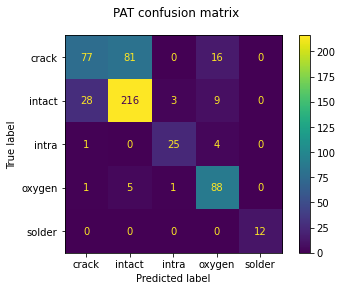

In [254]:
draw_confusion(model_rf_aug_few.best_estimator_, x_test, y_test, le, title='PAT confusion matrix')
plt.savefig('../plots/rf_aug_few_confusion_matrix.png', dpi=600)

In [65]:
pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)).to_pickle('results2/rf_report.pkl')
pd.DataFrame(metrics.classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True))

,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.674797,0.703822,0.923077,0.869565,1.0,0.740741,0.834252,0.740554
recall,0.477011,0.863281,0.800000,0.842105,1.0,0.740741,0.796480,0.740741
f1-score,0.558923,0.775439,0.857143,0.855615,1.0,0.740741,0.809424,0.731504
support,174.000000,256.000000,30.000000,95.000000,12.0,0.740741,567.000000,567.000000


## RF with oversampling and without augumentation

In [66]:
from imblearn.over_sampling import ADASYN

In [67]:
ada = ADASYN(random_state=42)
x_train_res, y_train_res =  ada.fit_resample(x_train, y_train)

In [68]:
model_rf_res = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_para_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1)
model_rf_res.fit(x_train_res, y_train_res)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 40, 60, 80, 100,
                                                      None],
                                        'n_estimators': [10, 20, 30, 40, 50, 80,
                                                         100, 200, 400, 1000]},
                   random_state=42)

In [82]:
def output_all(models, X_train, Y_train, X_test, Y_test, le, name, path=Path('results2')):
    os.makedirs(path/name, exist_ok=True)

    best_model = models.best_estimator_
    joblib.dump(best_model, str(path/name/(name+'_model.pkl')))
    pd.DataFrame(models.cv_results_).to_pickle(str(path/name/(name+'_history.pkl')))

    with open(str(path/name/(name+'_best_para.json')), 'w') as f:
        json.dump(models.best_params_, f)

    print(models.best_params_)
    print(best_model.score(X_train, Y_train), best_model.score(X_test, Y_test))

    draw_confusion(best_model, X_test, Y_test, le)
    plt.savefig(str(path/name/(name+'_confusion_matrix.png')), dpi=600)

    Y_pred = best_model.predict(X_test)
    test_report = pd.DataFrame(metrics.classification_report(Y_test, Y_pred, target_names=le.classes_, output_dict=True))
    test_report.to_pickle(str(path/name/(name+'_report.pkl')))
    return test_report

{'n_estimators': 1000, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
1.0 0.7477954144620811
['crack' 'intact' 'intra' 'oxygen' 'solder']
[0 1 2 3 4]
Confusion matrix:
[[102  61   1  10   0]
 [ 52 201   1   1   1]
 [  1   0  25   4   0]
 [  3   6   2  84   0]
 [  0   0   0   0  12]]


,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.645570,0.750000,0.862069,0.848485,0.923077,0.747795,0.805840,0.744046
recall,0.586207,0.785156,0.833333,0.884211,1.000000,0.747795,0.817781,0.747795
f1-score,0.614458,0.767176,0.847458,0.865979,0.960000,0.747795,0.811014,0.745193
support,174.000000,256.000000,30.000000,95.000000,12.000000,0.747795,567.000000,567.000000


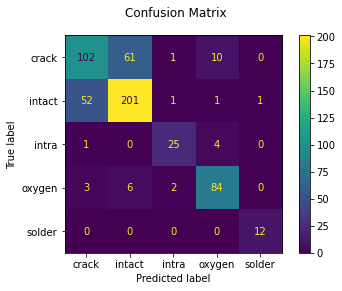

In [83]:
output_all(model_rf_res, x_train_res, y_train_res, x_test, y_test, le, name='rf_res', path=Path('results2'))

In [76]:
pd.read_pickle('results2/rf_res_report.pkl')

,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.645570,0.750000,0.862069,0.848485,0.923077,0.747795,0.805840,0.744046
recall,0.586207,0.785156,0.833333,0.884211,1.000000,0.747795,0.817781,0.747795
f1-score,0.614458,0.767176,0.847458,0.865979,0.960000,0.747795,0.811014,0.745193
support,174.000000,256.000000,30.000000,95.000000,12.000000,0.747795,567.000000,567.000000


In [78]:
model_rf_res.best_estimator_.score(x_train_res, y_train_res), model_rf_res.best_estimator_.score(x_test, y_test)

(1.0, 0.7477954144620811)

## rf with data aug, without oversampling

In [99]:
from sklearn import utils as sk_utils

In [166]:
y_train.shape

(5103,)

In [168]:
def im_aug(images, labels, shuffle=True, select_aug=False, select_inx=None):
    v_flip = []
    h_flip = []
    rotate = []
    labels_few = []

    if not select_aug:
        for image in images:
            v_flip.append(cv.flip(image, 0))
            h_flip.append(cv.flip(image, 1))
            rotate.append(cv.rotate(image, cv.ROTATE_180))
    elif select_aug:
        for i, image in enumerate(images):
            if labels[i] in select_inx:
                v_flip.append(cv.flip(image, 0))
                h_flip.append(cv.flip(image, 1))
                rotate.append(cv.rotate(image, cv.ROTATE_180))
                labels_few.append(labels[i])
    
    v_flip = np.array(v_flip)
    h_flip = np.array(h_flip)
    rotate = np.array(rotate)
    if not select_aug:
        x, y = np.concatenate((images, v_flip, h_flip, rotate)), np.concatenate((labels, labels, labels, labels))
    elif select_aug:
        labels_few = np.array(labels_few)
        x, y = np.concatenate((images, v_flip, h_flip, rotate)), np.concatenate((labels, labels_few, labels_few, labels_few))

    if shuffle:
        return sk_utils.shuffle(x, y)
    else:
        return x, y

In [101]:
#im_g_train = images_g[train_inx]
im_train_aug, y_train_aug = im_aug(x_train.reshape(len(x_train), 32, 32), y_train)
x_train_aug = im_flatten(im_train_aug)

In [102]:
model_rf_aug = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_para_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1)

model_rf_aug.fit(x_train_aug, y_train_aug)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 40, 60, 80, 100,
                                                      None],
                                        'n_estimators': [10, 20, 30, 40, 50, 80,
                                                         100, 200, 400, 1000]},
                   random_state=42)

{'n_estimators': 1000, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
1.0 0.7936507936507936
['crack' 'intact' 'intra' 'oxygen' 'solder']
[0 1 2 3 4]
Confusion matrix:
[[104  63   0   7   0]
 [ 34 221   0   1   0]
 [  1   0  26   3   0]
 [  2   6   0  87   0]
 [  0   0   0   0  12]]


,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.737589,0.762069,1.000000,0.887755,1.0,0.793651,0.877483,0.793240
recall,0.597701,0.863281,0.866667,0.915789,1.0,0.793651,0.848688,0.793651
f1-score,0.660317,0.809524,0.928571,0.901554,1.0,0.793651,0.859993,0.789485
support,174.000000,256.000000,30.000000,95.000000,12.0,0.793651,567.000000,567.000000


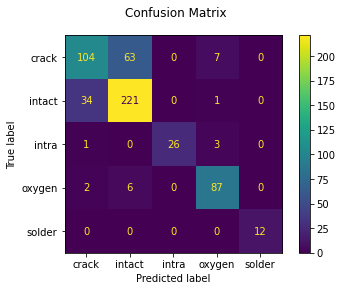

In [103]:
output_all(model_rf_aug, x_train_aug, y_train_aug, x_test, y_test, le, name='rf_aug', path=Path('results2'))

In [191]:
model_rf_aug.score(x_train_aug, y_train_aug), model_rf_aug.score(x_test, y_test)

(1.0, 0.7425044091710759)

# With few aug without oversampling

In [169]:
im_train_aug_few, y_train_aug_few = im_aug(x_train.reshape(len(x_train), 32, 32), y_train, select_aug=True, select_inx=[2,3,4])
x_train_aug_few = im_flatten(im_train_aug_few)

In [173]:
model_rf_aug_few = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=rf_para_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1)

model_rf_aug_few.fit(x_train_aug_few, y_train_aug_few)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 40, 60, 80, 100,
                                                      None],
                                        'n_estimators': [10, 20, 30, 40, 50, 80,
                                                         100, 200, 400, 1000]},
                   random_state=42)

{'n_estimators': 100, 'max_depth': 60, 'criterion': 'gini', 'bootstrap': False}
1.0 0.7372134038800705
['crack' 'intact' 'intra' 'oxygen' 'solder']
[0 1 2 3 4]
Confusion matrix:
[[ 77  81   0  16   0]
 [ 28 216   3   9   0]
 [  1   0  25   4   0]
 [  1   5   1  88   0]
 [  0   0   0   0  12]]


,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.719626,0.715232,0.862069,0.752137,1.0,0.737213,0.809813,0.736560
recall,0.442529,0.843750,0.833333,0.926316,1.0,0.737213,0.809186,0.737213
f1-score,0.548043,0.774194,0.847458,0.830189,1.0,0.737213,0.799977,0.722830
support,174.000000,256.000000,30.000000,95.000000,12.0,0.737213,567.000000,567.000000


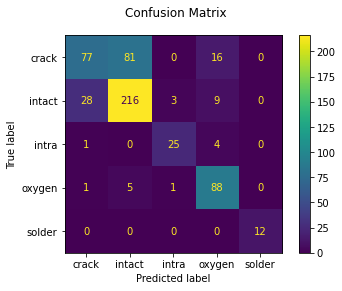

In [174]:
output_all(model_rf_aug_few, x_train_aug_few, y_train_aug_few, x_test, y_test, le, name='rf_aug_IntraSolderOxy', path=Path('results2'))

In [196]:
rf_report = pd.read_pickle('results2/rf/rf_report.pkl')
rf_aug_report = pd.read_pickle('results2/rf_aug/rf_aug_report.pkl')
rf_aug_few_report = pd.read_pickle('results2/rf_aug_IntraSolderOxy/rf_aug_IntraSolderOxy_report.pkl')

In [231]:
score_dic = {}
cols = ['intact', 'crack', 'oxygen', 'intra', 'solder']
for score in ['precision', 'recall', 'f1-score']:
    score_dic[score] = pd.DataFrame({
        'OT': rf_report.loc[score][cols],
        'AT': rf_aug_report.loc[score][cols],
        'PAT': rf_aug_few_report.loc[score][cols]
        })

In [207]:
import seaborn as sns

In [223]:
a.reset_index().rename(columns={"index":"Category"})

,Category,OT,AT,PAT
0,intact,0.703822,0.762069,0.715232
1,crack,0.674797,0.737589,0.719626
2,oxygen,0.869565,0.887755,0.752137
3,intra,0.923077,1.000000,0.862069
4,solder,1.000000,1.000000,1.000000


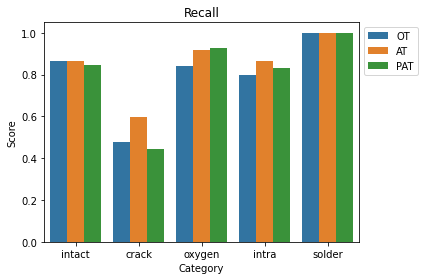

In [245]:
b = score_dic['recall'].reset_index().melt('index', var_name='training set', value_name='Score')
ax = sns.barplot(data=b, x='index', y='Score', hue='training set')
ax.set_title('Recall')
ax.set_xlabel('Category')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.tight_layout()
plt.savefig('../plots/recall.png', dpi=600)

In [433]:
prc_score = {
    'training set': ['OT', 'AT', 'PAT'],
    'RF': [0.83, 0.87, 0.83],
    'LeNet': [0.65, 0.63, 0.65],
    'ResNet18': [0.95, 0.92, 0.88],
    'ResNet50': [0.64, 0.95, 0.95] 
}

prc_score = pd.DataFrame(prc_score).melt('training set', var_name='model', value_name='micro PRC AUC')
prc_score

,training set,model,micro PRC AUC
0,OT,RF,0.83
1,AT,RF,0.87
2,PAT,RF,0.83
3,OT,LeNet,0.65
4,AT,LeNet,0.63
5,PAT,LeNet,0.65
6,OT,ResNet18,0.95
7,AT,ResNet18,0.92
8,PAT,ResNet18,0.88
9,OT,ResNet50,0.64


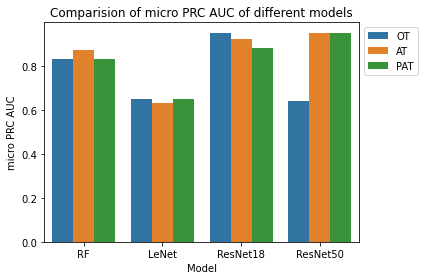

In [435]:
ax = sns.barplot(data=prc_score, x='model', y='micro PRC AUC', hue='training set')
ax.set_title('Comparision of micro PRC AUC of different models')
ax.set_xlabel('Model')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.tight_layout()
plt.savefig('../plots/prc_auc_compare.png', dpi=600)

## roc_prc curve

In [344]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import pickle

In [334]:
y_test_binary = label_binarize(y_test, classes = le.transform(le.classes_))

In [350]:
prob_test = model_rf_aug_few.best_estimator_.predict_proba(x_test)

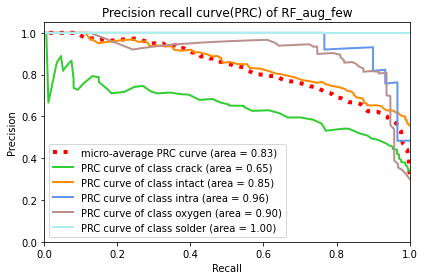

In [351]:
_ = get_prc_curve(y_test_binary, prob_test, le, plot=True, model_name='RF_aug_few', saveplace='roc_prc/')

In [458]:
m = nn.Softmax()
m(torch.from_numpy(prob_test[0])).sum()

tensor(1.)

In [456]:
torch.from_numpy(prob_test[0])

tensor([ 3.3751,  3.6663, -2.3510,  1.5052, -5.8605])

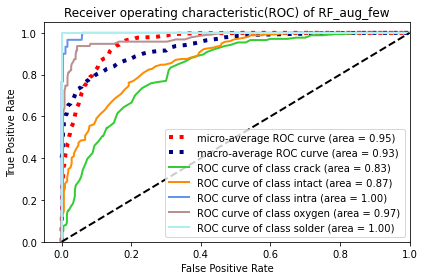

In [352]:
_ = get_roc_curve(y_test_binary, prob_test, le, plot=True, model_name='RF_aug_few', saveplace='roc_prc/')

In [339]:
def get_roc_curve(y_test_binary, prob_test, le, plot=False, saveplace=None, model_name=None):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in le.transform(le.classes_):
        fpr[le.classes_[i]], tpr[le.classes_[i]], _ = roc_curve(y_test_binary[:, i], prob_test[:, i])
        roc_auc[le.classes_[i]] = auc(fpr[le.classes_[i]], tpr[le.classes_[i]])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), prob_test.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    all_fpr = np.unique(np.concatenate([fpr[le.classes_[i]] for i in le.transform(le.classes_)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in le.transform(le.classes_):
        mean_tpr += np.interp(all_fpr, fpr[le.classes_[i]], tpr[le.classes_[i]])
        
    mean_tpr /= len(le.transform(le.classes_))

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    if plot:
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color='red', linestyle=':', linewidth=4)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)
        lw = 2
        colors = ['limegreen', 'darkorange', 'cornflowerblue', 'rosybrown', 'paleturquoise']
        for i, color in zip(le.transform(le.classes_), colors):
            plt.plot(fpr[le.classes_[i]], tpr[le.classes_[i]], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(le.classes_[i], roc_auc[le.classes_[i]]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic(ROC) of '+model_name)
        plt.legend(loc="lower right")
        plt.tight_layout()
        
    if saveplace:
        plt.savefig(saveplace+model_name+'_roc.png', dpi=600)
        with open(saveplace+model_name+'_roc.pkl', 'wb') as f:
            pickle.dump({'fpr':fpr, 'tpr':tpr, 'roc_auc':roc_auc}, f)
    
    return {'fpr':fpr, 'tpr':tpr, 'roc_auc':roc_auc}

In [337]:
def get_prc_curve(y_test_binary, prob_test, le, plot=False, saveplace=None, model_name=None):
    pre = dict()
    rec = dict()
    prc_auc = dict()
    for i in le.transform(le.classes_):
        pre[le.classes_[i]], rec[le.classes_[i]], _ = precision_recall_curve(y_test_binary[:, i], prob_test[:, i])
        prc_auc[le.classes_[i]] = average_precision_score(y_test_binary[:, i], prob_test[:, i])
    
    pre["micro"], rec["micro"], _ = precision_recall_curve(y_test_binary.ravel(), prob_test.ravel())
    prc_auc["micro"] = average_precision_score(y_test_binary.ravel(), prob_test.ravel(), average='micro')
    
    #all_pre = np.unique(np.concatenate([pre[le.classes_[i]] for i in le.transform(le.classes_)]))
    #mean_rec = np.zeros_like(all_pre)
    #for i in le.transform(le.classes_):
    #    mean_rec += np.interp(all_pre, pre[le.classes_[i]], rec[le.classes_[i]])
        
    #mean_rec /= len(le.transform(le.classes_))

    #pre["macro"] = all_pre
    #rec["macro"] = mean_rec
    prc_auc["macro"] = average_precision_score(y_test_binary.ravel(), prob_test.ravel(), average='macro')
    
    if plot:
        plt.figure()
        plt.plot(rec["micro"], pre["micro"],
                 label='micro-average PRC curve (area = {0:0.2f})'
                       ''.format(prc_auc["micro"]),
                 color='red', linestyle=':', linewidth=4)

        #plt.plot(pre["macro"], rec["macro"],
        #         label='macro-average PRC curve (area = {0:0.2f})'
        #               ''.format(prc_auc["macro"]),
        #         color='navy', linestyle=':', linewidth=4)
        lw = 2
        colors = ['limegreen', 'darkorange', 'cornflowerblue', 'rosybrown', 'paleturquoise']
        for i, color in zip(le.transform(le.classes_), colors):
            plt.plot(rec[le.classes_[i]], pre[le.classes_[i]], color=color, lw=lw,
                     label='PRC curve of class {0} (area = {1:0.2f})'
                     ''.format(le.classes_[i], prc_auc[le.classes_[i]]))

        #plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0, 1])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision recall curve(PRC) of '+model_name)
        plt.legend(loc="lower left")
        plt.tight_layout()
        
    if saveplace:
        plt.savefig(saveplace+model_name+'_prc.png', dpi=600)
        with open(saveplace+model_name+'_prc.pkl', 'wb') as f:
            pickle.dump({'pre':pre, 'rec':rec, 'prc_auc':prc_auc}, f)
    
    return {'pre':pre, 'rec':rec, 'prc_auc':prc_auc}

# Try SVM

In [104]:
from sklearn import svm

## without oversampling and aug

In [105]:
svm_para_grid={
    'C': [10, 100, 1000, 1e4, 1e5],
    'gamma': [1e-4, 1e-3, 1e-2, 0.1, 1]
}

In [106]:
model_svm = RandomizedSearchCV(estimator=svm.SVC(kernel='rbf'), param_distributions=svm_para_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1)

model_svm.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [10, 100, 1000, 10000.0, 100000.0],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
                   random_state=42)

{'gamma': 0.0001, 'C': 10}
1.0 0.4514991181657848
['crack' 'intact' 'intra' 'oxygen' 'solder']
[0 1 2 3 4]
Confusion matrix:
[[  0 174   0   0   0]
 [  0 256   0   0   0]
 [  0  30   0   0   0]
 [  0  95   0   0   0]
 [  0  12   0   0   0]]


,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.0,0.451499,0.0,0.0,0.0,0.451499,0.090300,0.203851
recall,0.0,1.000000,0.0,0.0,0.0,0.451499,0.200000,0.451499
f1-score,0.0,0.622114,0.0,0.0,0.0,0.451499,0.124423,0.280884
support,174.0,256.000000,30.0,95.0,12.0,0.451499,567.000000,567.000000


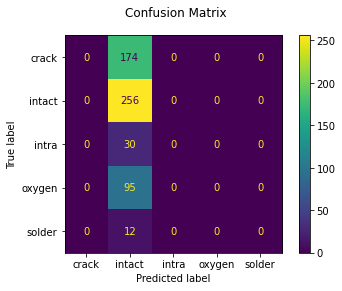

In [107]:
output_all(model_svm, x_train, y_train, x_test, y_test, le, name='svm', path=Path('results2'))

In [303]:
joblib.dump(model_svm, 'moderl_svm.pkl')

['moderl_svm.pkl']

In [198]:
model_svm.score(x_train, y_train), model_svm.score(x_test, y_test)

(1.0, 0.4691358024691358)

In [202]:
## oversampling, without aug

In [200]:
model_svm_res = svm.SVC(kernel='rbf', C=100, gamma=0.01)
model_svm_res.fit(x_train_res, y_train_res)

SVC(C=100, gamma=0.01)

In [305]:
joblib.dump(model_svm_res, 'moderl_svm_res.pkl')

['moderl_svm_res.pkl']

In [205]:
model_svm_res.score(x_train_res, y_train_res), model_svm_res.score(x_test, y_test)

(1.0, 0.2927689594356261)

## aug without oversampling

In [203]:
model_svm_aug = svm.SVC(kernel='rbf', C=100, gamma=0.01)
model_svm_aug.fit(x_train_aug, y_train_aug)

SVC(C=100, gamma=0.01)

In [304]:
joblib.dump(model_svm_aug, 'moderl_svm_aug.pkl')

['moderl_svm_aug.pkl']

In [204]:
model_svm_aug.score(x_train_aug, y_train_aug), model_svm_aug.score(x_test, y_test)

(1.0, 0.4691358024691358)

# Try Lenet

In [109]:
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import copy, random

In [5]:
# skip this if the dataset is loaded above
im_dir = Path('classified_cells')

labels = []
images = []

for im_path in tqdm(list(list_images(im_dir))):
    images.append(cv.imread(im_path))
    labels.append(im_path.split('/')[1])

images = np.array(images)

le = LabelEncoder()
y = le.fit_transform(labels)
print(le.classes_, le.transform(le.classes_))

100%|██████████| 5670/5670 [00:05<00:00, 967.86it/s]
['crack' 'intact' 'intra' 'oxygen' 'solder'] [0 1 2 3 4]


In [110]:
class OneRotationTransform:
    """Rotate by one given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

solar_transform_train = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    OneRotationTransform([0,180]),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]) 

solar_transform_val = transforms.Compose([
    #transforms.RandomVerticalFlip(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]) 

In [112]:
class SolarDataset(Dataset):
    def __init__(self, images, labels, transform, transform2=None, inx_aug=None):
        self.images = images
        self.labels = torch.from_numpy(labels)
        self.transform = transform
        self.transform2 = transform2
        self.inx_aug = inx_aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(cv.cvtColor(self.images[idx], cv.COLOR_BGR2RGB))
        label = self.labels[idx]
        if self.transform2:
            if label in self.inx_aug:
                image = self.transform(image)
            else:
                image = self.transform2(image)
        else:
            image = self.transform(image)
        
        
        return image, label

In [301]:
def result_plot(epochs, loss_accuracy, title, name=None):
    plt.plot(range(epochs), loss_accuracy['train'][0], label='train_loss')
    plt.plot(range(epochs), loss_accuracy['val'][0], label='val_loss')
    plt.plot(range(epochs), loss_accuracy['train'][1], label='train_acc')
    plt.plot(range(epochs), loss_accuracy['val'][1], label='val_acc')
    plt.xlabel('Epoches')
    plt.ylabel('Score')
    plt.title(title)
    plt.grid(linestyle='--')
    plt.legend()
    if name:
        plt.tight_layout()
        plt.savefig(name, dpi=600)

In [120]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    loss_acc = {
        'train': [[],[]],
        'val': [[],[]]
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = trainloader
                dataset_size = len(solar_train)
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valloader
                dataset_size = len(solar_val)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                labels = labels.long()
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            loss_acc[phase][0].append(epoch_loss)
            loss_acc[phase][1].append(float(epoch_acc))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_acc

In [410]:
im_train, im_test, y_train, y_test = train_test_split(images, y, test_size=0.1, shuffle=True, random_state=42)
im_train, im_val, y_train, y_val = train_test_split(im_train, y_train, test_size=0.2, shuffle=True, random_state=42)

solar_train = SolarDataset(im_train, y_train, transform=solar_transform_train, transform2=solar_transform_val, inx_aug=[2, 3, 4]) # determine whether to use aug
solar_val = SolarDataset(im_val, y_val, transform=solar_transform_val)
solar_test = SolarDataset(im_test, y_test, transform=solar_transform_val)

trainloader = DataLoader(solar_train, batch_size=8, shuffle=True)
valloader = DataLoader(solar_val, batch_size=8, shuffle=True)

In [411]:
model = LeNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [412]:
model_fit, loss_acc = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=20)

  4%|▎         | 18/511 [00:00<00:02, 172.58it/s]Epoch 0/19
----------
  4%|▍         | 21/511 [00:00<00:02, 202.75it/s]val Loss: 1.1134 Acc: 0.4535

Epoch 1/19
----------
  4%|▍         | 20/511 [00:00<00:02, 193.20it/s]val Loss: 1.0024 Acc: 0.5416

Epoch 2/19
----------
  4%|▍         | 20/511 [00:00<00:02, 192.57it/s]val Loss: 0.9130 Acc: 0.5622

Epoch 3/19
----------
  4%|▎         | 19/511 [00:00<00:02, 185.85it/s]val Loss: 0.8123 Acc: 0.6219

Epoch 4/19
----------
  4%|▍         | 21/511 [00:00<00:02, 200.77it/s]val Loss: 0.7825 Acc: 0.6376

Epoch 5/19
----------
  4%|▎         | 18/511 [00:00<00:02, 175.12it/s]val Loss: 0.7110 Acc: 0.6484

Epoch 6/19
----------
  3%|▎         | 13/511 [00:00<00:03, 128.98it/s]val Loss: 0.7127 Acc: 0.6464

Epoch 7/19
----------
  3%|▎         | 15/511 [00:00<00:03, 147.08it/s]val Loss: 0.6810 Acc: 0.6611

Epoch 8/19
----------
  4%|▍         | 20/511 [00:00<00:02, 194.66it/s]val Loss: 0.6767 Acc: 0.6621

Epoch 9/19
----------
  4%|▎         | 18/

In [413]:
name = 'lenet_aug_IntraSolderOxy'
#os.makedirs('LeNet_results/'+name, exist_ok=True)

#result_plot(20, loss_acc, title='LeNet loss-accuracy trained on OT', name='LeNet_results/'+name+'/'+name+'.png')

In [414]:
with open('LeNet_results/'+name+'/'+name+'.json', 'w') as f:
    json.dump(loss_acc, f)

In [406]:
torch.save(model_fit.state_dict(), 'LeNet_results/'+name+'/'+name+'.pth')

In [418]:
model_fit = LeNet()

model_fit.load_state_dict(torch.load('LeNet_results/lenet/lenet.pth')) 
model_fit.eval();

In [443]:
model_fit.eval()

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=5, bias=True)
)

In [419]:
pred_test = []
prob_test = []
corrects = 0
testloader = DataLoader(solar_test, batch_size=1, shuffle=False)
with torch.no_grad():
    for input, label in tqdm(testloader):
        #input = input.to(device)
        label = label.long()
        #label = label.to(device)
        
        output = model_fit(input)
        prob_test.append(output.numpy()[0])
        _, pred = torch.max(output, 1)
        pred_test.append(int(pred))
        corrects += torch.sum(pred == label.data)

prob_test = np.array(prob_test)
acc_test = corrects.double() / len(solar_test)
acc_test

100%|██████████| 567/567 [00:00<00:00, 1143.21it/s]


tensor(0.6843, dtype=torch.float64)

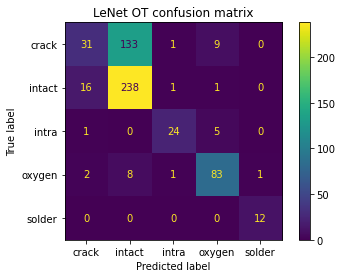

In [408]:
cm = metrics.confusion_matrix(y_test, pred_test)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=le.classes_)

disp.plot()
plt.title('LeNet OT confusion matrix')
plt.savefig('../plots/lenet/lenet_cm.png', dpi=600)

In [409]:
test_report = pd.DataFrame(metrics.classification_report(y_test, pred_test, target_names=le.classes_, output_dict=True))
test_report.to_pickle('LeNet_results/'+name+'/'+name+'_report.pkl')
test_report

,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.620000,0.627968,0.888889,0.846939,0.923077,0.684303,0.781375,0.682262
recall,0.178161,0.929688,0.800000,0.873684,1.000000,0.684303,0.756307,0.684303
f1-score,0.276786,0.749606,0.842105,0.860104,0.960000,0.684303,0.737720,0.632368
support,174.000000,256.000000,30.000000,95.000000,12.000000,0.684303,567.000000,567.000000


In [279]:
def bar_plot(OT, AT, PAT, model, output, out_dir):
    ot_report = pd.read_pickle(OT)
    at_report = pd.read_pickle(AT)
    pat_report = pd.read_pickle(PAT)

    score_dic = {}
    cols = ['intact', 'crack', 'oxygen', 'intra', 'solder']
    for score in ['precision', 'recall', 'f1-score']:
        score_dic[score] = pd.DataFrame({
            'OT': ot_report.loc[score][cols],
            'AT': at_report.loc[score][cols],
            'PAT': pat_report.loc[score][cols]
            })
    b = score_dic[output].reset_index().melt('index', var_name='training set', value_name='Score')
    ax = sns.barplot(data=b, x='index', y='Score', hue='training set')
    ax.set_title((model+output).title())
    ax.set_xlabel('Category')
    plt.legend(bbox_to_anchor=(1,1), loc=2)
    plt.tight_layout()
    plt.savefig(out_dir+model+output+'.png', dpi=600)

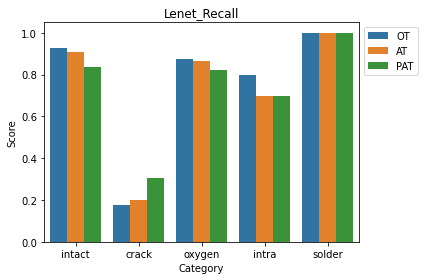

In [417]:
bar_plot(OT='LeNet_results/lenet/lenet_report.pkl', 
         AT='LeNet_results/lenet_aug/lenet_aug_report.pkl',
         PAT='LeNet_results/lenet_aug_IntraSolderOxy/lenet_aug_IntraSolderOxy_report.pkl',
         model = 'lenet_', output='recall', out_dir='../plots/lenet/')

In [420]:
pd.read_pickle('LeNet_results/lenet/lenet_report.pkl')

,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.620000,0.627968,0.888889,0.846939,0.923077,0.684303,0.781375,0.682262
recall,0.178161,0.929688,0.800000,0.873684,1.000000,0.684303,0.756307,0.684303
f1-score,0.276786,0.749606,0.842105,0.860104,0.960000,0.684303,0.737720,0.632368
support,174.000000,256.000000,30.000000,95.000000,12.000000,0.684303,567.000000,567.000000


In [327]:
pd.read_pickle('../CNN/resnet_results3/resnet18_aug_few_report.pkl')

,crack,intact,intra,oxygen,solder,accuracy,macro avg,weighted avg
precision,0.912791,0.926641,0.960000,0.929293,1.0,0.925926,0.945745,0.926153
recall,0.902299,0.937500,0.800000,0.968421,1.0,0.925926,0.921644,0.925926
f1-score,0.907514,0.932039,0.872727,0.948454,1.0,0.925926,0.932147,0.925563
support,174.000000,256.000000,30.000000,95.000000,12.0,0.925926,567.000000,567.000000


In [421]:
y_test_binary = label_binarize(y_test, classes = le.transform(le.classes_))

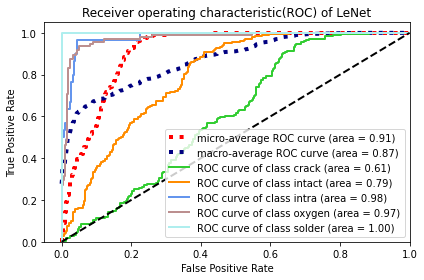

In [422]:
_ = get_roc_curve(y_test_binary, prob_test, le, plot=True, model_name='LeNet', saveplace='roc_prc/')


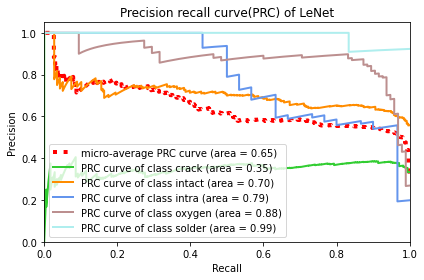

In [423]:
_ = get_prc_curve(y_test_binary, prob_test, le, plot=True, model_name='LeNet', saveplace='roc_prc/')

In [374]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x.float())))
        x = self.pool(F.relu(self.conv2(x)))
        #x = F.relu(self.conv3(x))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
